## Obspy ground-motion movie using just AuSIS



In [1]:
import obspy
from obspy.clients.fdsn import Client



In [2]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
from matplotlib.transforms import blended_transform_factory

import os

plt.style.use(['seaborn-poster'])


In [3]:
# event_name = "Broome6.6i"
# event_time = obspy.UTCDateTime('2019-07-14T05:39:24')
# event_lat = -18.269
# event_lon = 120.294
# window_start = event_time - 60
# window_end = window_start + 30*60
# fmin = 0.01
# fmax = 0.033
# scale = 1.0e4
# sample_loc1 = "AUDHS"
# sample_loc2 = "AUSIS"

event_name = "Laiwui7.3"
event_time = obspy.UTCDateTime('2019-07-14T09:10:50')
event_lat = -0.53
event_lon = 128.09
window_start = event_time + 150 
window_end   = window_start + 1500
fmin = 0.01
fmax = 0.02
scale=1.0e5
sample_loc1 = "AUDHS"
sample_loc2 = "AUSIS"


# event_name = "Fiji7.9"
# event_time = obspy.UTCDateTime('2018-09-06T15:49:18')
# event_lat = -18.47	
# event_lon = 179.35
# window_start = event_time + 60 
# window_end   = window_start + 40*60
# fmin = 0.01
# fmax = 0.033
# scale=1.0e5
# sample_loc1 = "AUDHS"
# sample_loc2 = "AUSIS"


# event_name = "Namatanai7.6"
# event_time = obspy.UTCDateTime('2019-05-14T12:58:25')
# event_lat = -4.05
# event_lon = 152.60
# window_start = event_time + 60 
# window_end   = window_start + 30*60
# fmin = 0.001
# fmax = 0.02
# scale=1.0e5
# sample_loc1 = "AUAYR"
# sample_loc2 = "AUHAR"

# event_name = "Peru8.0"
# event_time = obspy.UTCDateTime('2019-05-26T07:41:15')
# event_lat = -5.81
# event_lon = 360.0-75.27
# window_start = event_time + 1000 
# window_end   = window_start + 70*60
# fmin = 0.015
# fmax = 0.025
# scale=1.0e5
# sample_loc1 = "AUBUS"
# sample_loc2 = "AUTOO"


In [4]:
if not os.path.isdir(event_name):
    os.mkdir(event_name)

In [5]:
cl = Client('http://auspass.edu.au:80')

In [6]:
inv = cl.get_stations(network='S1',station='*',starttime=window_start,endtime=window_end)

In [7]:
stz  = cl.get_waveforms('S1','*','*','BHZ',window_start, window_end, attach_response=True)
ste  = cl.get_waveforms('S1','*','*','BHE',window_start, window_end, attach_response=True)
stn  = cl.get_waveforms('S1','*','*','BHN',window_start, window_end, attach_response=True)

In [8]:
# For this purpose, fragments are not helpful so eliminate them

for stream in (stz, ste, stn):

    mean_npoints = 0
    for t in stream:
        mean_npoints += t.meta.npts
    mean_npoints /= len(stream)

    for t in stream:
        if t.meta.npts < mean_npoints * 0.5:
            stream.remove(t)


In [9]:
st2z = stz.copy()
st2z.filter(type='bandpass',freqmin=fmin,freqmax=fmax)
st2z.merge()

st2e = ste.copy()
st2e.filter(type='bandpass',freqmin=fmin,freqmax=fmax)
st2e.merge()

st2n = stn.copy()
st2n.filter(type='bandpass',freqmin=fmin,freqmax=fmax)
st2n.merge()

pass

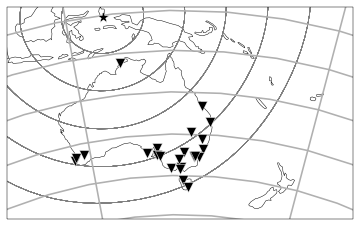

In [10]:
lat = event_lat
lon = event_lon

fig = plt.figure()
# Define the Cartopy Projection
maxlat = 0.
minlat = -50
maxlon = 190
minlon = 100
lat0 = (maxlat + minlat)/2.0
lon0 = (maxlon + minlon)/2.0
proj_kwargs={}
proj_kwargs['central_latitude'] = lat0
proj_kwargs['central_longitude'] = lon0
proj_kwargs['standard_parallels'] = [lat0,lat0]
proj = ccrs.AlbersEqualArea(**proj_kwargs)
map_ax = fig.add_axes([0.1,0.1,0.8,0.8],projection=proj)
x0, y0 = proj.transform_point(lon0, lat0, proj.as_geodetic())
deg2m_lat = 2 * np.pi * 6371 * 1000 / 360
deg2m_lon = deg2m_lat * np.cos(lat0 / 180 * np.pi)
height = (maxlat - minlat) * deg2m_lat
width = (maxlon - minlon) * deg2m_lon
map_ax.set_xlim(x0 - width / 2, x0 + width / 2)
map_ax.set_ylim(y0 - height / 2, y0 + height / 2)

# Plot the Coastlines
map_ax.coastlines()

# Plot the Parallels and Meridians
map_ax.gridlines()

# Plot the source with a star
map_ax.scatter(lon, lat, marker="*", s=150, zorder=10,
                color="k", edgecolor="w", transform = proj.as_geodetic())

import warnings
warnings.filterwarnings("ignore")

# Plot the station with data with a triangle, and the path source-reciever
for station in inv[0]:
    if len(stz.select(station=station.code))!=0:
        map_ax.scatter(station.longitude, station.latitude, marker="v", s=100, zorder=10,
                 color="k", edgecolor="w", transform = proj.as_geodetic())
        map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=1000, edgecolor="grey", facecolor="none", linewidth=0.5 )
        map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=2000, edgecolor="grey", facecolor="none", linewidth=0.5 )
        map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=3000, edgecolor="grey", facecolor="none", linewidth=0.5 )
        map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=4000, edgecolor="grey", facecolor="none", linewidth=0.5 )
        map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=5000, edgecolor="grey", facecolor="none", linewidth=0.5 )


In [11]:
warnings.filterwarnings("default")

In [12]:
# We need to add the distance information by hand ... 

for st2 in (st2n, st2e, st2z):
    for station in inv[0]:
        if len(st2.select(station=station.code))!=0:
            tr = st2.select(station=station.code)[0]
            tr.stats.coordinates = {}
            tr.stats.coordinates["latitude"]  = station.latitude
            tr.stats.coordinates["longitude"] = station.longitude


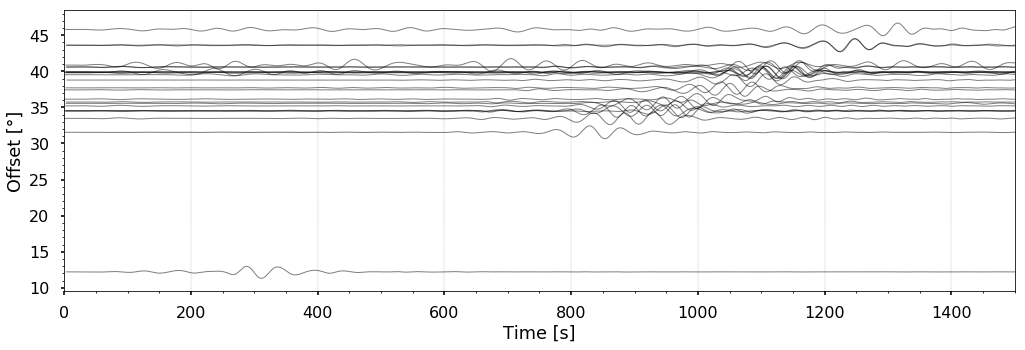

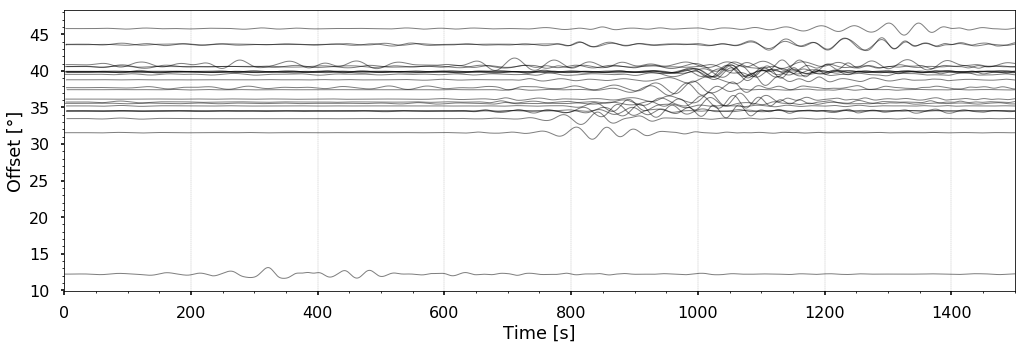

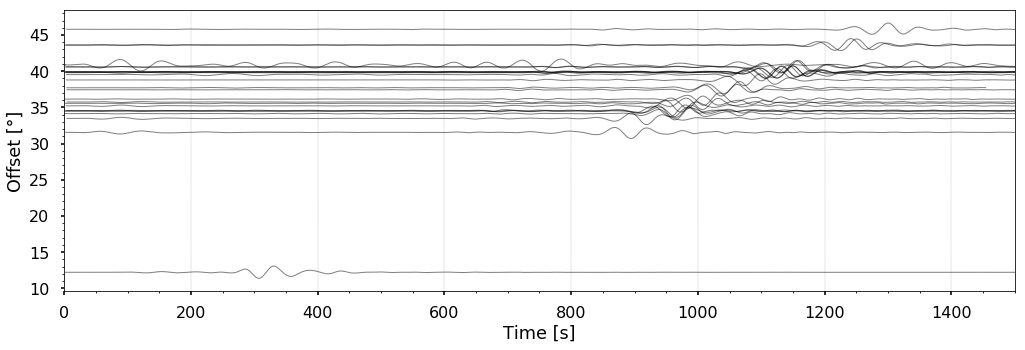

In [13]:
for st2 in (st2n, st2e, st2z):
    fig = plt.figure(figsize=(15,5))
    st2.plot(type='section', dist_degree=True, recordlength=window_end-window_start, ev_coord=(event_lat,event_lon),
             time_down=True, linewidth=1, grid_linewidth=.25, show=False, fig=fig, norm_method='trace', orientation='horizontal')

    plt.show()

In [14]:
for tr in st2e:
     print("station:{} @ ({:7.3f},{:7.3f}) ... {}".format(tr.stats.station, 
                                                tr.stats.coordinates.latitude, 
                                                tr.stats.coordinates.longitude,
                                                tr.stats.npts))

station:AUBRN @ (-41.041,145.868) ... 15342
station:AUBSH @ (-26.864,152.955) ... 15196
station:AUBUS @ (-33.660,115.383) ... 15121
station:AUCAS @ (-34.264,135.722) ... 15232
station:AUDAR @ (-35.253,149.138) ... 15227
station:AUDHS @ (-12.440,130.833) ... 15379
station:AUGRF @ (-34.286,146.059) ... 15205
station:AUHAR @ (-33.093,115.891) ... 15176
station:AUHPC @ (-38.107,142.318) ... 15044
station:AUKHS @ (-33.464,151.383) ... 15297
station:AUKSC @ (-37.968,145.158) ... 15152
station:AUKUL @ (-32.670,118.152) ... 15221
station:AULRC @ (-29.426,147.979) ... 15021
station:AUMAG @ (-36.102,144.748) ... 15176
station:AUMAR @ (-34.892,138.636) ... 15288
station:AUMBR @ (-35.134,139.286) ... 15161
station:AUMHS @ (-35.364,149.089) ... 15124
station:AUMTS @ (-35.319,148.996) ... 15356
station:AUNRC @ (-23.353,150.533) ... 15459
station:AUPHS @ (-31.099,150.894) ... 15053
station:AUPKL @ (-41.081,145.901) ... 15254
station:AURSC @ (-38.368,144.887) ... 15207
station:AUSIS @ (-35.284,149.115

In [15]:
# sample_loc1 = "AUALC"
# sample_loc2 = "AUTOO"

station:AUDHS @ (-12.44,130.833)


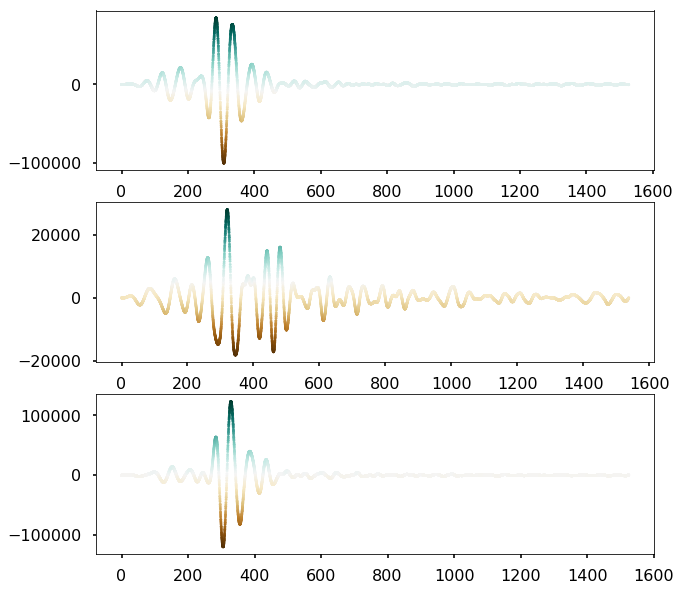

station:AUSIS @ (-35.2839,149.1147)


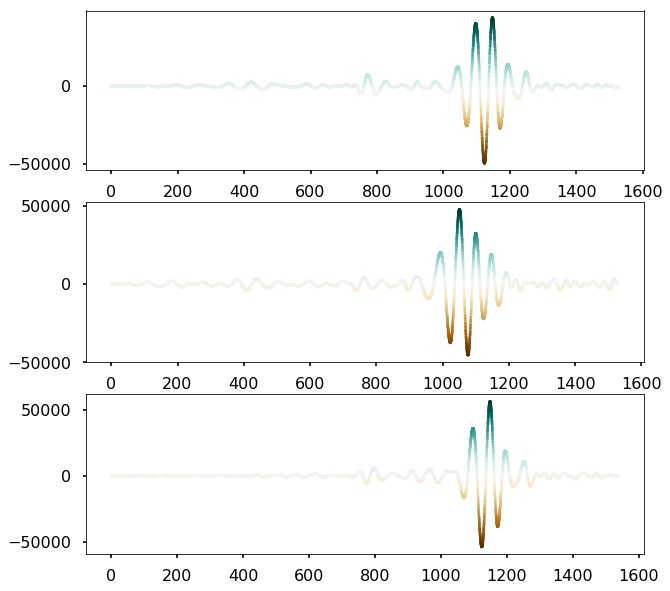

In [16]:
import matplotlib

for id in [ sample_loc1, sample_loc2]:

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax1  = plt.subplot(311)
    ax2  = plt.subplot(312)
    ax3  = plt.subplot(313)

    trn = st2n.select(station=id)[0]
    tre = st2e.select(station=id)[0]
    trz = st2z.select(station=id)[0]

    print("station:{} @ ({},{})".format(id, trn.meta.coordinates.latitude, trn.meta.coordinates.longitude))

    cmapper= matplotlib.cm.BrBG
    norm   = matplotlib.colors.Normalize(vmin=-scale,vmax=scale)

    tr = trn
    times = tr.times()
    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax1.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=matplotlib.cm.BrBG, s=5)


    tr = tre
    times = tr.times()
    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax2.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=matplotlib.cm.BrBG, s=5)

    tr = trz
    times = tr.times()
    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax3.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=matplotlib.cm.BrBG, s=5)
    
    plt.show()



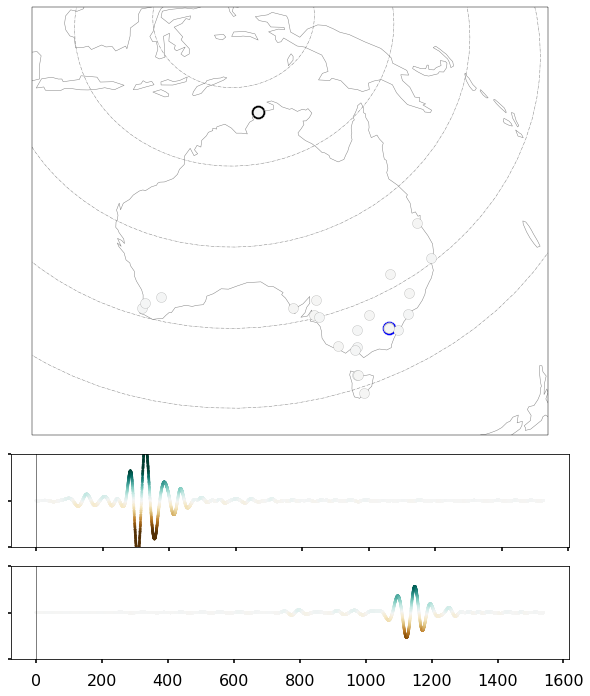

In [21]:
## Trial frame


warnings.filterwarnings("ignore")

def plot_at_time(this_time, stream, sample_no1, sample_no2, scale, savefig=None):
    import matplotlib.gridspec as gridspec

    tr1=stream.select(station=sample_loc1)[0]
    tr2=stream.select(station=sample_loc2)[0]
    
    fig = plt.figure(figsize=(10, 12), facecolor="none")
    gridspec.GridSpec(6,4)
    ax = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4, 
                          projection=ccrs.Orthographic(central_longitude=130.0, central_latitude=-30, globe=None))
    
    
    ## Map

    ax.coastlines(color="grey")
    ax.set_extent([105, 165, 2.0, -45])
    
#     ax.scatter(event_lon, event_lat, marker="*", s=150, zorder=10,
#                 color="k", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.scatter(tr1.stats.coordinates.longitude, tr1.stats.coordinates.latitude, s=200, zorder=0,
                color="black", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.scatter(tr2.stats.coordinates.longitude, tr2.stats.coordinates.latitude, s=200, zorder=0,
                color="blue", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=1000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=2000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=3000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=4000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=5000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )

    cmapper= matplotlib.cm.BrBG
    norm   = matplotlib.colors.Normalize(vmin=-scale*0.666,vmax=scale*0.666)
   
    for station in inv[0]:
        if len(stream.select(station=station.code))!=0:
            
            trace = stream.select(station=station.code)[0]
            idx   = np.searchsorted(trace.times(), this_time, side="left")
            if idx != len(trace.times()):        
                color = cmapper(norm(trace.data[idx]))
                ax.scatter(station.longitude, station.latitude, marker="o", s=100, zorder=11, 
                             color=color, edgecolor="black", linewidth=0.1, transform = ccrs.Geodetic())

            
    ## Sample trace # 1
    
    ax2 = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=1)
    ax2.set_ylim(-scale,scale)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    tr = tr1 
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax2.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=matplotlib.cm.BrBG, s=5, vmin=-scale*0.666, vmax=scale*0.666)
    
    ## Draw a line on the trace
    
    ax2.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    

    ## Sample trace # 2
    
    ax3 = plt.subplot2grid((6,4), (5,0), colspan=4, rowspan=1)
    ax3.set_ylim(-scale,scale)
    ax3.set_yticklabels([])

    tr = tr2
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    
    ax3.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=matplotlib.cm.BrBG, s=5, vmin=-scale*0.666, vmax=scale*0.666)

    ## Draw a line on the trace
    
    ax3.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    

    if savefig is not None:
        fig.savefig(savefig)
    else:
        plt.show()
    
    plt.close(fig)


plot_at_time(0.0, st2z, sample_loc1, sample_loc2, scale)


In [22]:
cmapper= matplotlib.cm.BrBG
norm   = matplotlib.colors.Normalize(vmin=-scale,vmax=scale)
signals = st2n


import warnings
warnings.filterwarnings("ignore")

for i, delta_time in enumerate(np.arange(0.0,window_end-window_start, 1.0)):   
    if i%10 == 0:
        print("Plotting frame {} delta t = {}".format(i, delta_time))
    plot_at_time(delta_time, st2n, sample_loc1, sample_loc2, scale, savefig="{}/EQSIS.{:04d}.png".format(event_name,i))



Plotting frame 0 delta t = 0.0
Plotting frame 10 delta t = 10.0
Plotting frame 20 delta t = 20.0
Plotting frame 30 delta t = 30.0
Plotting frame 40 delta t = 40.0
Plotting frame 50 delta t = 50.0
Plotting frame 60 delta t = 60.0
Plotting frame 70 delta t = 70.0
Plotting frame 80 delta t = 80.0
Plotting frame 90 delta t = 90.0
Plotting frame 100 delta t = 100.0
Plotting frame 110 delta t = 110.0
Plotting frame 120 delta t = 120.0
Plotting frame 130 delta t = 130.0
Plotting frame 140 delta t = 140.0
Plotting frame 150 delta t = 150.0
Plotting frame 160 delta t = 160.0
Plotting frame 170 delta t = 170.0
Plotting frame 180 delta t = 180.0
Plotting frame 190 delta t = 190.0
Plotting frame 200 delta t = 200.0
Plotting frame 210 delta t = 210.0
Plotting frame 220 delta t = 220.0
Plotting frame 230 delta t = 230.0
Plotting frame 240 delta t = 240.0
Plotting frame 250 delta t = 250.0
Plotting frame 260 delta t = 260.0
Plotting frame 270 delta t = 270.0
Plotting frame 280 delta t = 280.0
Plottin

In [23]:
import os
import imageio

path = event_name


fileList = []
for file in sorted(os.listdir(path)):
    if "EQSIS" in file:
        full_path = os.path.join(path,file)
        fileList.append(full_path)

writer = imageio.get_writer('{}.mp4'.format(event_name), fps=50)

for im in fileList:
    writer.append_data(imageio.imread(im))
    
writer.close()

